# Librosa vs Opensmile

https://github.com/PrudhviGNV/Speech-Emotion-Recognization

內核:affective_computing

In [7]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [8]:
audio_files = []
for path, subdirs, files in os.walk("./data/RAVDESS"):
    for name in files:
        audio_files.append(os.path.join(path, name))


# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these emotions
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}

In [9]:
sample_x, sampling_rate = librosa.load(audio_files[0], sr=44100)

## Librosa

In [10]:
# get the base name of the audio file4
X = []
y = []
file_location_x = './model/saved_audio_file_X.pkl'
file_location_y = './model/saved_audio_file_y.pkl'
if os.path.isfile(file_location_x):
    with open(file_location_x, 'rb') as handle:
        X = pickle.load(handle)
    with open(file_location_y, 'rb') as handle:
        y = pickle.load(handle)
else:
    #for file in audio_files:
    for file in tqdm(audio_files):
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        audio_time_series , sample_rate = librosa.load(file) #audio time series
        stft = np.abs(librosa.stft(audio_time_series))    
        result = np.array([])
        #40個特徵
        mfccs = np.mean(librosa.feature.mfcc(y=audio_time_series, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
        #12個特徵
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
        #128個特徵
        mel = np.mean(librosa.feature.melspectrogram(y=audio_time_series, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
        #7個特徵
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
        #6個特徵
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_time_series), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))

        # add to data
        X.append(result)
        y.append(emotion)
    with open(file_location_x, 'wb') as handle:
        pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(file_location_y, 'wb') as handle:
        pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/1440 [00:00<?, ?it/s]

In [126]:
print(np.array(X).shape)
print(np.array(y).shape)

(1440, 6373)
(1440,)


In [127]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=7)

In [128]:
feature_names = [f"feature {i}" for i in range(np.array(X).shape[1])]
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0) 
classifier.fit(X_train, y_train)  
c_p = classifier.predict(X_test) 
print(accuracy_score(y_true=y_test,y_pred=c_p))
print(classification_report(y_test,c_p)) 
print(confusion_matrix(y_test,c_p) )


0.5555555555555556
              precision    recall  f1-score   support

       angry       0.70      0.59      0.64        32
        calm       0.55      0.87      0.67        38
     disgust       0.62      0.59      0.60        44
     fearful       0.42      0.62      0.50        29
       happy       0.44      0.45      0.44        40
     neutral       0.25      0.10      0.14        20
         sad       0.33      0.24      0.28        42
   surprised       0.92      0.79      0.85        43

    accuracy                           0.56       288
   macro avg       0.53      0.53      0.52       288
weighted avg       0.55      0.56      0.54       288

[[19  0  3  2  5  0  1  2]
 [ 0 33  1  2  0  1  1  0]
 [ 0  7 26  2  3  1  5  0]
 [ 1  1  0 18  3  2  4  0]
 [ 6  2  2  6 18  2  3  1]
 [ 0 10  2  0  2  2  4  0]
 [ 1  7  7 12  5  0 10  0]
 [ 0  0  1  1  5  0  2 34]]


### Feature importance based on mean decrease in impurity¶

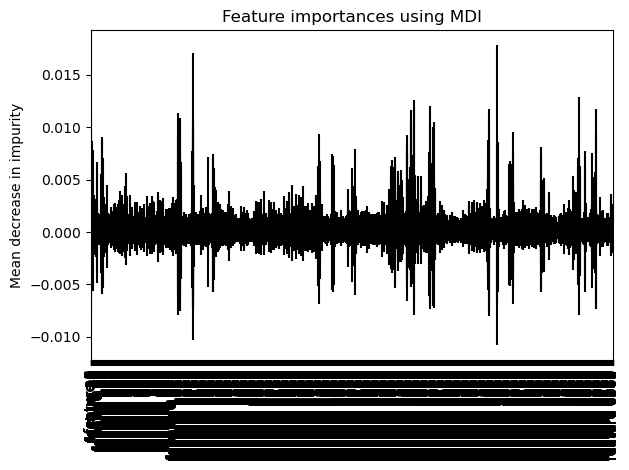

In [129]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Feature importance based on feature permutation

In [130]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

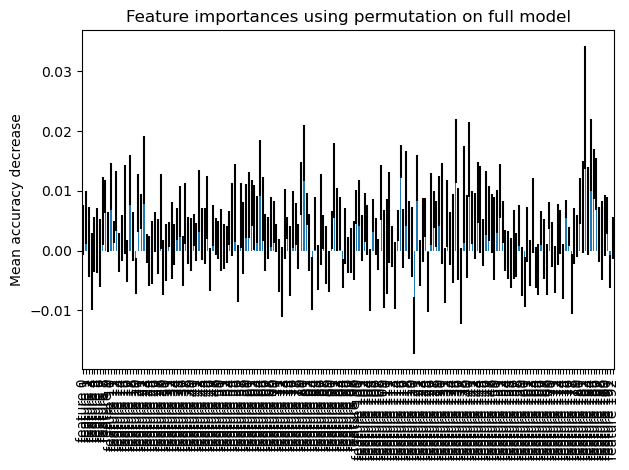

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

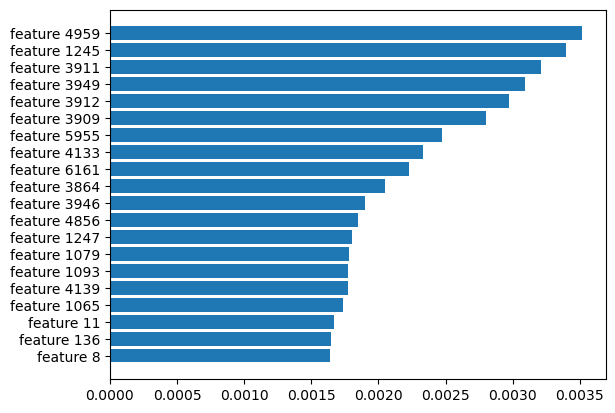

In [ ]:
f_i = list(zip(feature_names,classifier.feature_importances_))
f_i.sort(key = lambda x : x[1])
f_i_top = f_i[-20:]
plt.barh([x[0] for x in f_i_top],[x[1] for x in f_i_top])
plt.show()

### 加上PCA

In [45]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca_n_of_dim = 5
pca = PCA(n_components=pca_n_of_dim)
pca.fit(X_train_scaled)

# transform data onto the first two principal components
X_trained_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("Original shape: {}".format(str(X_train_scaled.shape)))
print("Reduced shape: {}".format(str(X_train_scaled.shape)))

Original shape: (1152, 193)
Reduced shape: (1152, 193)


In [46]:
classifier.fit(X_trained_pca, y_train)  
c_p = classifier.predict(X_test_pca) 
print(accuracy_score(y_true=y_test,y_pred=c_p))
print(classification_report(y_test,c_p)) 
print(confusion_matrix(y_test,c_p) )

0.375
              precision    recall  f1-score   support

       angry       0.58      0.59      0.58        32
        calm       0.39      0.55      0.46        38
     disgust       0.29      0.25      0.27        44
     fearful       0.35      0.48      0.41        29
       happy       0.25      0.20      0.22        40
     neutral       0.17      0.10      0.12        20
         sad       0.43      0.36      0.39        42
   surprised       0.41      0.42      0.41        43

    accuracy                           0.38       288
   macro avg       0.36      0.37      0.36       288
weighted avg       0.36      0.38      0.37       288

[[19  0  5  4  2  0  0  2]
 [ 1 21  1  1  1  5  5  3]
 [ 3  7 11  4 10  1  4  4]
 [ 3  2  3 14  1  0  3  3]
 [ 4  2  7  7  8  3  1  8]
 [ 0 13  0  0  1  2  2  2]
 [ 2  5  4  7  4  1 15  4]
 [ 1  4  7  3  5  0  5 18]]


In [50]:
acc_list = []
range_list = range(3,20)
for pca_n_of_dim in range_list:
    pca = PCA(n_components=pca_n_of_dim)
    pca.fit(X_train_scaled)
    X_trained_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    classifier.fit(X_trained_pca, y_train)  
    c_p = classifier.predict(X_test_pca) 
    acc_list.append(accuracy_score(y_true=y_test,y_pred=c_p))

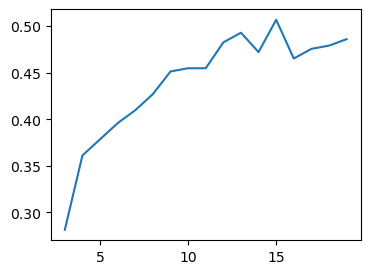

In [51]:
plt.figure(figsize = (4, 3))  
plt.plot(range_list, acc_list)
plt.show()    # show plot

In [55]:
pca_n_of_dim = 15
pca = PCA(n_components=pca_n_of_dim)
pca.fit(X_train_scaled)
X_trained_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
classifier.fit(X_trained_pca, y_train)
feature_names_pca = [f"feature {i}" for i in range(np.array(X_trained_pca).shape[1])]

In [56]:
result = permutation_importance(
    classifier, X_test_pca, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names_pca)

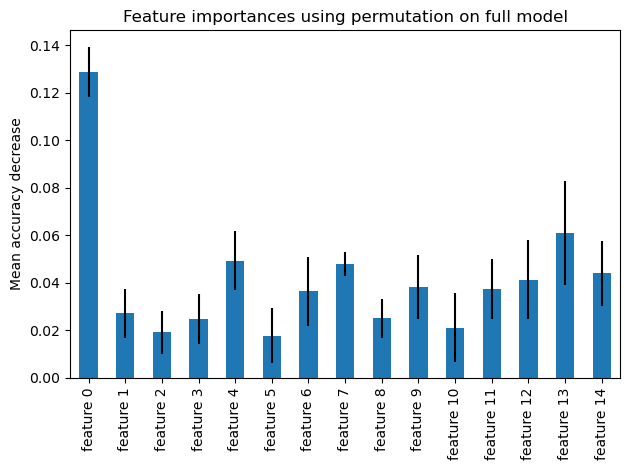

In [57]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## opensmile

In [82]:
import opensmile
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)


In [96]:
features = smile.process_file("./data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav")
feature_names_smile = list(features.columns)

In [84]:


# get the base name of the audio file4
X = []
y = []
file_location_smile_x = './model/saved_audio_file_opensmile_X.pkl'
file_location_smile_y = './model/saved_audio_file_opensmile_y.pkl'
if os.path.isfile(file_location_smile_x):
    with open(file_location_smile_x, 'rb') as handle:
        X = pickle.load(handle)
    with open(file_location_smile_y, 'rb') as handle:
        y = pickle.load(handle)
else:
    for file in tqdm(audio_files):
        basename = os.path.basename(file)
        processed = smile.process_file(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # add to data
        X.append(np.array(processed)[0])
        y.append(emotion)
    with open(file_location_smile_x, 'wb') as handle:
        pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(file_location_smile_y, 'wb') as handle:
        pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [85]:
print(np.array(X).shape)
print(np.array(y).shape)

(1440, 6373)
(1440,)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=7)

In [87]:
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0) 
classifier.fit(X_train, y_train)  
c_p = classifier.predict(X_test) 
print(accuracy_score(y_true=y_test,y_pred=c_p))
print(classification_report(y_test,c_p)) 
print(confusion_matrix(y_test,c_p) )


0.5555555555555556
              precision    recall  f1-score   support

       angry       0.70      0.59      0.64        32
        calm       0.55      0.87      0.67        38
     disgust       0.62      0.59      0.60        44
     fearful       0.42      0.62      0.50        29
       happy       0.44      0.45      0.44        40
     neutral       0.25      0.10      0.14        20
         sad       0.33      0.24      0.28        42
   surprised       0.92      0.79      0.85        43

    accuracy                           0.56       288
   macro avg       0.53      0.53      0.52       288
weighted avg       0.55      0.56      0.54       288

[[19  0  3  2  5  0  1  2]
 [ 0 33  1  2  0  1  1  0]
 [ 0  7 26  2  3  1  5  0]
 [ 1  1  0 18  3  2  4  0]
 [ 6  2  2  6 18  2  3  1]
 [ 0 10  2  0  2  2  4  0]
 [ 1  7  7 12  5  0 10  0]
 [ 0  0  1  1  5  0  2 34]]


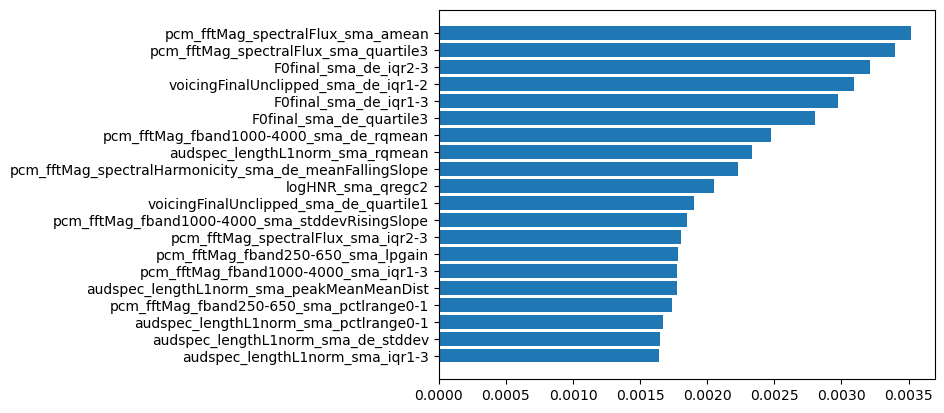

In [116]:
f_i = list(zip(feature_names_smile,classifier.feature_importances_))
f_i.sort(key = lambda x : x[1])
f_i_top = f_i[-20:]
plt.barh([x[0] for x in f_i_top],[x[1] for x in f_i_top])
plt.show()

### 加上PCA

In [59]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
acc_list = []
range_list = range(3,20)
for pca_n_of_dim in range_list:
    pca = PCA(n_components=pca_n_of_dim)
    pca.fit(X_train_scaled)
    X_trained_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    classifier.fit(X_trained_pca, y_train)  
    c_p = classifier.predict(X_test_pca) 
    acc_list.append(accuracy_score(y_true=y_test,y_pred=c_p))

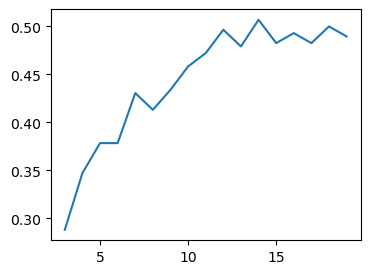

In [61]:
plt.figure(figsize = (4, 3))  
plt.plot(range_list, acc_list)
plt.show()    # show plot

In [62]:
pca_n_of_dim = 12
pca = PCA(n_components=pca_n_of_dim)
pca.fit(X_train_scaled)
X_trained_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
classifier.fit(X_trained_pca, y_train)
feature_names_pca = [f"feature {i}" for i in range(np.array(X_trained_pca).shape[1])]

In [63]:
result = permutation_importance(
    classifier, X_test_pca, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names_pca)

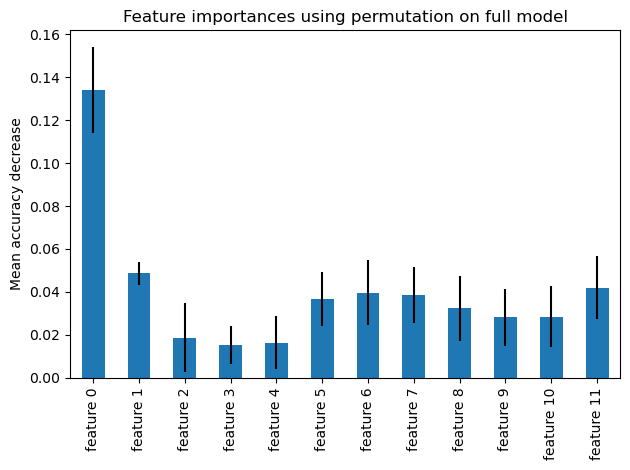

In [64]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

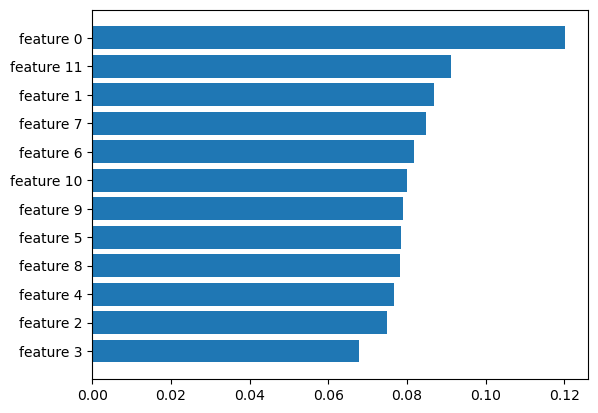

In [65]:
f_i = list(zip(feature_names_pca,classifier.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.show()